## Skip-gram using pytorch
2019.11.05 NLP 스터디

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import Counter
import random, math
import itertools
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
dev

device(type='cuda')

### 1. 데이터 로드

In [4]:
with open("./data/tokenized/korquad_mecab.txt", 'r') as korquad:
    corpus = korquad.readlines()
corpus = [line.strip() for line in corpus]

In [5]:
corpus[0]

'1 8 3 9 년 바그너 는 괴테 의 파우스트 을 처음 읽 고 그 내용 에 마음 이 끌려 이 를 소재 로 해서 하나 의 교향곡 을 쓰 려는 뜻 을 갖 는다 . 이 시기 바그너 는 1 8 3 8 년 에 빛 독촉 으로 산전수전 을 다 걲은 상황 이 라 좌절 과 실망 에 가득 했으며 메피스토펠레스 를 만나 는 파우스트 의 심경 에 공감 했 다고 한다 . 또한 파리 에서 아 브네 크 의 지휘 로 파리 음악원 관현악단 이 연주 하 는 베토벤 의 교향곡 9 번 을 듣 고 깊 은 감명 을 받 았 는데 , 이것 이 이듬해 1 월 에 파우스트 의 서곡 으로 쓰여진 이 작품 에 조금 이 라도 영향 을 끼쳤 으리라는 것 은 의심 할 여지 가 없 다 . 여기 의 라단조 조성 의 경우 에 도 그 의 전기 에 적혀 있 는 것 처럼 단순 한 정신 적 피로 나 실의 가 반영 된 것 이 아니 라 베토벤 의 합창 교향곡 조성 의 영향 을 받 은 것 을 볼 수 있 다 . 그렇게 교향곡 작곡 을 1 8 3 9 년 부터 4 0 년 에 걸쳐 파리 에서 착수 했으나 1 악장 을 쓴 뒤 에 중단 했 다 . 또한 작품 의 완성 과 동시 에 그 는 이 서곡 ( 1 악장 ) 을 파리 음악원 의 연주회 에서 연주 할 파트 보 까지 준비 하 였으나 , 실제로 는 이루 어 지지 는 않 았 다 . 결국 초연 은 4 년 반 이 지난 후 에 드레스덴 에서 연주 되 었 고 재연 도 이루 어 졌 지만 , 이후 에 그대로 방치 되 고 말 았 다 . 그 사이 에 그 는 리엔치 와 방황 하 는 네덜란드인 을 완성 하 고 탄호이저 에 도 착수 하 는 등 분주 한 시간 을 보냈 는데 , 그런 바쁜 생활 이 이 곡 을 잊 게 한 것 이 아닌가 하 는 의견 도 있 다 .'

In [6]:
word_sequence = " ".join(corpus).split()

In [7]:
word_sequence[500:510]

['했', '다', '.', '이것', '을', '계기', '로', '바그너', '도', '이']

In [8]:
len(word_sequence) # 전체 word 갯수 (중복 포함)

4093756

## 2. subsampling 정의

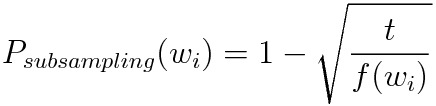

In [9]:
def subsampling(word_sequence):
    filtered_corpus = []
    word_counts = dict(Counter(word_sequence)) # Counter를 이용해 단어 빈도수 체크
    sum_word_counts = sum(list(word_counts.values())) # 단어 전체 등장 횟수
    word_freq = {word: word_counts[word]/float(sum_word_counts) for word in word_counts} # 단어 등장 횟수 / 전체 단어 등장 횟수
    for word in word_sequence:
        if 1-math.sqrt(1e-5 / word_freq[word]) <= 0: # 확률이 0보다 작으면 무조건 포함.
            filtered_corpus.append(word)
        elif 1-math.sqrt(1e-5 / word_freq[word]) > random.random(): # 서브샘플링 확률이 랜덤확률보다 높은 경우, 포함.
            filtered_corpus.append(word)
    return filtered_corpus

In [10]:
filtered_corpus = subsampling(word_sequence)

In [11]:
filtered_corpus[:10]

['1', '3', '9', '년', '바그너', '괴테', '의', '파우스트', '을', '처음']

In [12]:
len(filtered_corpus) # 기존 4,093,756 개에서 3,470,137 개로 줆음.

3469013

## 3. Train 데이터 만들기

In [13]:
vocab = list(set(filtered_corpus)) # tuple로 중복을 제거하여 vocabulary를 만듦

In [14]:
len(vocab) # Vocabulary size

83334

In [15]:
word_to_idx = dict()
for word in vocab:
    word_to_idx[word] = len(word_to_idx)

In [16]:
word_to_idx

{'블라디보스톡': 0,
 '러키': 1,
 'AMI': 72786,
 '거사': 59942,
 '걸릴': 2,
 '서이': 45650,
 'El': 4,
 '납짝': 5,
 '정랑': 6,
 '欽': 9,
 '소폴란드': 10,
 '삼부회': 13,
 'th': 12,
 '담보부': 55560,
 'Melanie': 14,
 '충당': 15,
 '이력': 17,
 '라이우': 21,
 'Poirot': 18,
 '산토리': 19,
 '승하차': 23,
 '社告': 22,
 'Mentoring': 34845,
 '우즈베키스탄': 25,
 '가워': 27,
 '사우스웨스트': 28,
 '붓다': 29,
 'CRIA': 55562,
 '찾아내': 23819,
 'consiliere': 30,
 'Plumer': 60296,
 'Higby': 31,
 '목성': 32,
 '마운틴': 34,
 'annonae': 35,
 '밀려든': 65741,
 '杻': 3735,
 '넘어섰': 36,
 '재인': 27853,
 '페더럴': 38,
 '이미자': 73591,
 '醫務': 39,
 '임금제': 40,
 '머나먼': 42,
 '염흥방': 65620,
 '선할': 45,
 '봉호': 46,
 '이부형제': 47,
 'Bukang': 48,
 '흥신': 49,
 '감별': 13768,
 '北靑': 50,
 '놀이': 41836,
 '촉한': 51,
 '온주': 52,
 'Lannes': 13770,
 '貼': 53,
 '악송구': 54,
 '노린다면': 55,
 '칼자국': 59,
 '러서야': 57,
 '조동근': 58,
 '입수': 70879,
 '이합집산': 78805,
 '반탁': 60,
 'Комитет': 55569,
 '정축': 59665,
 '行政': 61,
 '반비례': 62,
 'Epix': 63,
 '벙가로': 64,
 '굶': 65,
 '가라오케': 68,
 '오먼': 69,
 '말먹이': 73239,
 '신검': 70,
 '농노제': 50970,
 

In [17]:
idx_to_word = []
for word in word_to_idx.keys():
    idx_to_word.append(word)

In [18]:
idx_to_word

['블라디보스톡',
 '러키',
 'AMI',
 '거사',
 '걸릴',
 '서이',
 'El',
 '납짝',
 '정랑',
 '欽',
 '소폴란드',
 '삼부회',
 'th',
 '담보부',
 'Melanie',
 '충당',
 '이력',
 '라이우',
 'Poirot',
 '산토리',
 '승하차',
 '社告',
 'Mentoring',
 '우즈베키스탄',
 '가워',
 '사우스웨스트',
 '붓다',
 'CRIA',
 '찾아내',
 'consiliere',
 'Plumer',
 'Higby',
 '목성',
 '마운틴',
 'annonae',
 '밀려든',
 '杻',
 '넘어섰',
 '재인',
 '페더럴',
 '이미자',
 '醫務',
 '임금제',
 '머나먼',
 '염흥방',
 '선할',
 '봉호',
 '이부형제',
 'Bukang',
 '흥신',
 '감별',
 '北靑',
 '놀이',
 '촉한',
 '온주',
 'Lannes',
 '貼',
 '악송구',
 '노린다면',
 '칼자국',
 '러서야',
 '조동근',
 '입수',
 '이합집산',
 '반탁',
 'Комитет',
 '정축',
 '行政',
 '반비례',
 'Epix',
 '벙가로',
 '굶',
 '가라오케',
 '오먼',
 '말먹이',
 '신검',
 '농노제',
 'KE',
 '주희',
 '경단',
 '통치',
 'intensively',
 '민둥산',
 '팔로스',
 '이효봉',
 '草烏',
 '거민',
 '은덕',
 '린데만',
 '재갈',
 '코트니',
 '접속사',
 'Telecaster',
 'EUROX',
 '用語',
 '광훈',
 '덴메이',
 'Sachsenhausen',
 '반도핑',
 'YOUTH',
 '진편',
 '톱타자',
 '아가시',
 '추념',
 '외워',
 '모방',
 'Margaret',
 '씌여진',
 '연애관',
 '파이프라인',
 'Fool',
 'WKBL',
 'Bead',
 '당황',
 '색니',
 '문화청',
 '허혈',
 '諸',
 '훈의',
 'Unplugged'

In [19]:
train_input = []
train_target = []

In [22]:
w = 2     # window size = 2
dim = 100 # embedding vector 차원

In [23]:
for i in range(w, len(filtered_corpus) -w):
    for k in range(2*w):
        train_input.append(word_to_idx[filtered_corpus[i]])
    context= []
    for j in range(-w, w+1):
        if j != 0:
            context.append(word_to_idx[filtered_corpus[i+j]])
    train_target.append(context)

In [24]:
train_input[0], train_target[0]

(24926, [24437, 19531, 68845, 82100])

In [25]:
len(train_input)

13876036

In [26]:
len(train_target)

3469009

In [27]:
train_target = np.array(train_target).reshape(-1,) # train_target을 1차원 배열로 만듦.

In [28]:
train_input[0], train_target[0]

(24926, 24437)

In [29]:
len(train_target)

13876036

In [30]:
train = torch.utils.data.TensorDataset(torch.tensor(train_input), torch.tensor(train_target))

## 4. 모델 정의

In [31]:
class Skipgram(nn.Module):
    def __init__(self, dim):
        super(Skipgram, self).__init__()
        self.embedding = nn.Embedding(len(vocab), dim)
        self.linear = nn.Linear(dim, len(vocab))
    
    def forward(self, inputs):
        embeds = self.embedding(inputs)
        outs = self.linear(embeds)
        log_probs = F.log_softmax(outs)
        return log_probs

In [32]:
batch_size = 2000 # batch size 
input_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True) # dataloader 정의

In [33]:
model = Skipgram(dim).to(dev)

In [34]:
model.to(dev)

Skipgram(
  (embedding): Embedding(83334, 100)
  (linear): Linear(in_features=100, out_features=83334, bias=True)
)

In [35]:
loss_fn = nn.CrossEntropyLoss() # loss function = cross entropy 함수

In [36]:
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [37]:
epoch = 50
check = 5000

## 5. 모델 학습

In [38]:
start = time.time()

loss_list = []

for epo in range(epoch):
    loss_sum = 0
    for i, (x, y) in enumerate(input_loader):
        
        x, y = x.to(dev), y.to(dev)
        optimizer.zero_grad()

        output = model(x)

        
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        
        loss_sum += loss.item()
        
        if i % check == 0 and i != 0:
            elap = int(time.time() - start)
            loss_list.append(loss_sum/check)
            print('Epoch: {}, Iteration : {}, Loss : {:.2f}, Elapsed time: {:.0f}h {:.0f}m {}s'.format(\
                    epo, i, loss_sum / check, elap // 3600, (elap % 3600) // 60, str(int((elap % 3600) % 60))))
            loss_sum = 0

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:10: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  # Remove the CWD from sys.path while we load stuff.


Epoch: 0, Iteration : 5000, Loss : 6.49, Elapsed time: 0h 5m 28s
Epoch: 1, Iteration : 5000, Loss : 6.15, Elapsed time: 0h 13m 8s
Epoch: 2, Iteration : 5000, Loss : 6.07, Elapsed time: 0h 20m 47s
Epoch: 3, Iteration : 5000, Loss : 6.04, Elapsed time: 0h 28m 26s
Epoch: 4, Iteration : 5000, Loss : 6.03, Elapsed time: 0h 36m 6s
Epoch: 5, Iteration : 5000, Loss : 6.02, Elapsed time: 0h 43m 45s
Epoch: 6, Iteration : 5000, Loss : 6.01, Elapsed time: 0h 51m 23s
Epoch: 7, Iteration : 5000, Loss : 6.01, Elapsed time: 0h 59m 1s
Epoch: 8, Iteration : 5000, Loss : 6.01, Elapsed time: 1h 6m 39s
Epoch: 9, Iteration : 5000, Loss : 6.01, Elapsed time: 1h 14m 17s
Epoch: 10, Iteration : 5000, Loss : 6.01, Elapsed time: 1h 21m 55s
Epoch: 11, Iteration : 5000, Loss : 6.00, Elapsed time: 1h 29m 36s
Epoch: 12, Iteration : 5000, Loss : 6.00, Elapsed time: 1h 37m 15s
Epoch: 13, Iteration : 5000, Loss : 6.00, Elapsed time: 1h 44m 53s
Epoch: 14, Iteration : 5000, Loss : 6.00, Elapsed time: 1h 52m 31s
Epoch: 15,

In [39]:
def similar_words(model, word, k=10):
    cos = nn.CosineSimilarity(dim=1, eps=1e-6)
    
    word_id = torch.tensor([word_to_idx[word]])
    word_vec = model.embedding(word_id)
#     print(word_vec)
    word_mat = next(iter(model.embedding.parameters())).detach()
    print(word_mat.size)
    cos_mat = cos(word_vec, word_mat)
    sim, indices = torch.topk(cos_mat,k+1)
    
    
    word_list = []
    for i in indices:
        if i != word_id:
            word_list.append(idx_to_word[i])
    return word_list, sim[1:].detach()

In [40]:
similar_words(model.to('cpu'), '대통령')

<built-in method size of Tensor object at 0x7f2f36d1bab0>


(['바킬리데스', '만루', '삼복', '티시', '명령자', '화나', '던진다', '화력', '다지만', '서둘러선'],
 tensor([0.5409, 0.5298, 0.5269, 0.5051, 0.5023, 0.4814, 0.4785, 0.4785, 0.4742,
         0.4686]))

In [41]:
torch.save(model.state_dict(), "./data/word-embeddings/word2vec/word2vec_skipgram_korquad_epoch50")